<a href="https://colab.research.google.com/github/AfrizalDS/MachineLearning/blob/Jobsheet-10/Praktikum_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Nama Anggota Kelompok**
1.   Afrizal Dwi Septian /2241720122
2.   Dennis Parulian Panjaitan / 2241720182
2.   Dido Imam Padmanegara / 2241720111
2.   Muhammad Paksi / 2241720150


# **Praktikum 1**
## RNN untuk Analisis Sentimen


## **Setup**

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [115]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [116]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
 plt.plot(history.history['val_'+metric], '')
 plt.plot(history.history[metric])
 plt.xlabel("Epochs")
 plt.ylabel(metric)
 plt.legend([metric, 'val_'+metric])

## **Setup input pipeline**

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan ***TFDS***. Lihat ***loading text tutorial*** jika ingin me load data secara manual

In [117]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [118]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [119]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'Was this movie stupid? Yup. Did this movie depth? Nope. Character development? Nope. Plot twists? Nope. This was simply a movie about a highly-fictionalized Springer show. It shows the lengths that some people will go to get their mugs on TV. Molly Hagan did a great job as Jaime Pressly\'s mom. Jaime is....well...GORGEOUS! This flick wasn\'t so much made to be a "breakthrough" movie, rather, it was intended to life in a trailer park (I live in a trailer park and ours is nothing like the one in this movie) where everyone sleeps with everyone else, all the girls get pregnant by different guys, and all the guys drive rusted-out \'66 Ford pickups (exaggeration, of course, but that\'s the picture everyone sees when you mention "trailer park"). Some people over-analyze movies (case-in-point: Star Trek freaks). I watch movies purely for the entertainment value; not to point out that the girl is wearing a different shirt in a different scene (read the "Goofs" bit about Connie\'s shi

## **Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [120]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [121]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [127]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 14,  11,  18, ...,   0,   0,   0],
       [ 11,  64,  43, ...,   0,   0,   0],
       [  4, 468,   1, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:
- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [128]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Was this movie stupid? Yup. Did this movie depth? Nope. Character development? Nope. Plot twists? Nope. This was simply a movie about a highly-fictionalized Springer show. It shows the lengths that some people will go to get their mugs on TV. Molly Hagan did a great job as Jaime Pressly\'s mom. Jaime is....well...GORGEOUS! This flick wasn\'t so much made to be a "breakthrough" movie, rather, it was intended to life in a trailer park (I live in a trailer park and ours is nothing like the one in this movie) where everyone sleeps with everyone else, all the girls get pregnant by different guys, and all the guys drive rusted-out \'66 Ford pickups (exaggeration, of course, but that\'s the picture everyone sees when you mention "trailer park"). Some people over-analyze movies (case-in-point: Star Trek freaks). I watch movies purely for the entertainment value; not to point out that the girl is wearing a different shirt in a different scene (read the "Goofs" bit about Connie\'s s

## **Buat Model**
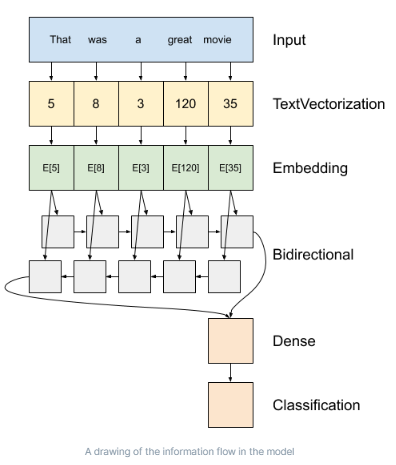

---
diagram model dapat dilihat pada gambar diatas
1. Model ini dapat dibuat sebagai tf.keras.Sequential.
2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.
3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.
4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.
  - Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.
  -Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.
5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

Kode nya adalah sebagai berikut :


In [129]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada Keras RNN guide

Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [130]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [131]:
# Sample text for prediction
sample_text = 'The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.'

# Wrap the text in a tf.constant to ensure compatibility
predictions = model.predict(tf.constant([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[-0.00886382]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [135]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(tf.constant([sample_text, padding]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
[-0.00886382]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [136]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## **Train Model**

In [137]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - accuracy: 0.5122 - loss: 0.6853 - val_accuracy: 0.6172 - val_loss: 0.5446
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 60ms/step - accuracy: 0.7826 - loss: 0.4452 - val_accuracy: 0.8099 - val_loss: 0.3765
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.8411 - loss: 0.3541 - val_accuracy: 0.8719 - val_loss: 0.3030
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.8536 - loss: 0.3350 - val_accuracy: 0.8542 - val_loss: 0.3297
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.8553 - loss: 0.3270 - val_accuracy: 0.8547 - val_loss: 0.3164
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.8604 - loss: 0.3179 - val_accuracy: 0.8234 - val_loss: 0.3609
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.8628 - loss: 0.3098 - val_accuracy: 0.8667 - val_loss: 0.3086
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.8684 - loss: 0.3064 - 

In [138]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8643 - loss: 0.3169
Test Loss: 0.3156828284263611
Test Accuracy: 0.8637199997901917


(0.0, 0.6691979840397835)

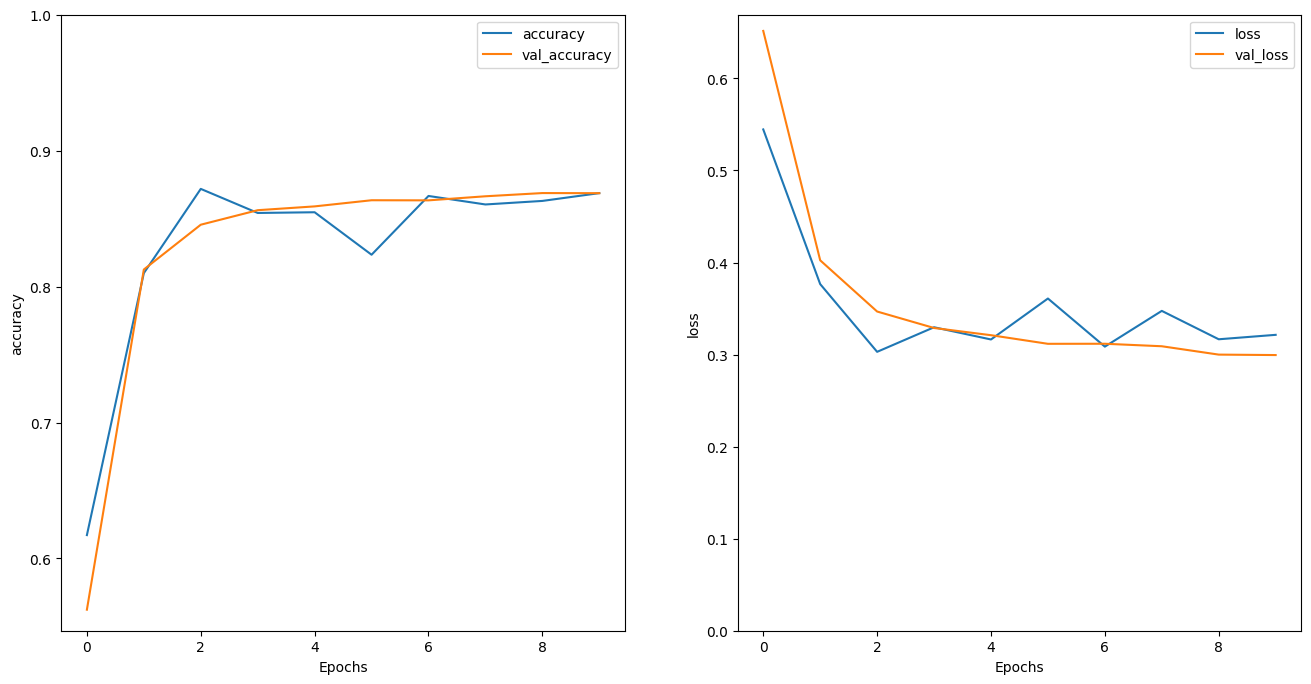

In [139]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [142]:
sample_text = ('The movie was cool. The animation and the graphics '
       'were out of this world. I would recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


## Stack two or more LSTM layers
Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :
- Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.
- Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

Berikut adalah alur informasi dengan return_sequences=True:

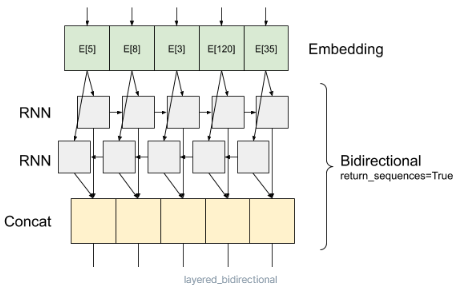

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [143]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [144]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [145]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 166s 119ms/step - accuracy: 0.5203 - loss: 0.6794 - val_accuracy: 0.7818 - val_loss: 0.4718
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 75s 107ms/step - accuracy: 0.7952 - loss: 0.4434 - val_accuracy: 0.8443 - val_loss: 0.3857
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 109ms/step - accuracy: 0.8408 - loss: 0.3650 - val_accuracy: 0.8578 - val_loss: 0.3165
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms/step - accuracy: 0.8527 - loss: 0.3426 - val_accuracy: 0.8516 - val_loss: 0.3533
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 108ms/step - accuracy: 0.8631 - loss: 0.3242 - val_accuracy: 0.8672 - val_loss: 0.3157
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 107ms/step - accuracy: 0.8672 - loss: 0.3139 - val_accuracy: 0.8521 - val_loss: 0.3326
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 108ms/step - accuracy: 0.8654 - loss: 0.3135 - val_accuracy: 0.8609 - val_loss: 0.3064
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 95s 141ms/step - accuracy: 0.8646 - loss: 

In [146]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8581 - loss: 0.3153
Test Loss: 0.31487181782722473
Test Accuracy: 0.8575599789619446


In [148]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
       'were terrible. I would not recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
[[-1.625397]]


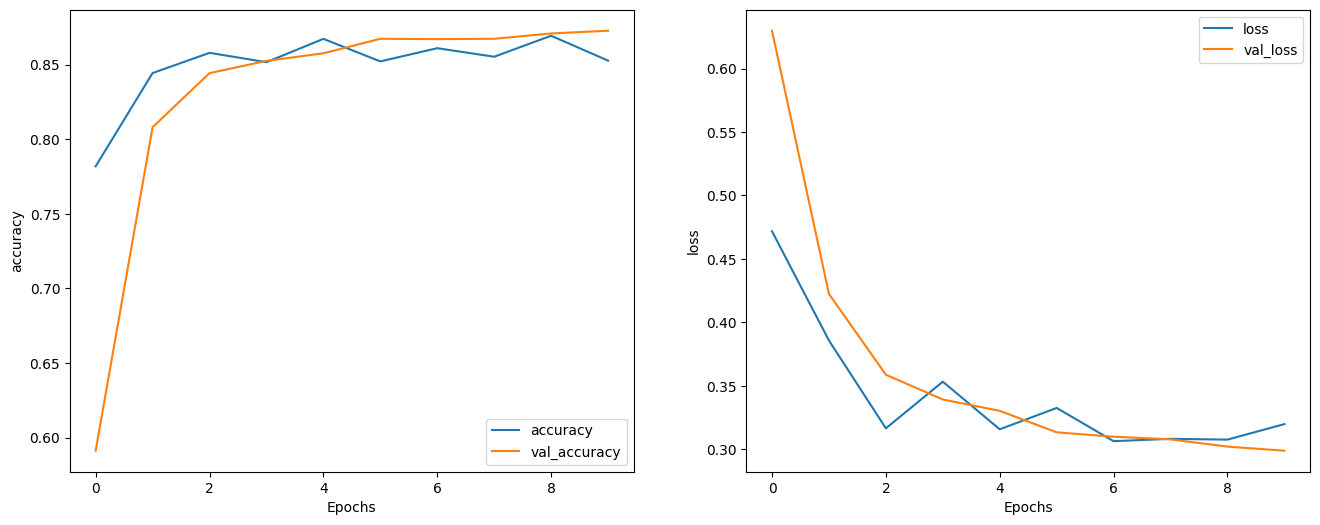

In [149]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')